# Project Report: Get The Gold!

## Introduction
This project focuses on applying different search strategies seen during the course to a customized Minihack environment defined by us: the gold room.

The studied scenarios consider full observability.

## The Environment
The gold room environment defined by us consists in a (square or rectangular) room filled with some pieces of gold (possibly zero) and some leprechauns (possibly zero). The aim of the agent (positioned in some point in the grid) is to reach the exit stairs, maximizing the gain.\
The leprechauns act as opponents because their main goal is also to take all the gold possible.

The environment behaviour can be summarized in the following points:
- Each step of the agent involves a negative reward.
- When the agent passes over the gold he gets a positive reward.
- An episode ends when the agent reaches the exit stairs or when the maximum number of steps is reached.
- The set of possible actions in each cell is given by the set of movements that lead to each of the adjacent cells (maximum 8).
- When the agent hits a leprechaun, a negative reward is returned.

The different instances of the environment considered in this work can be distinguished into deterministic instances (without leprechauns) and non deterministic instances (obtained inserting leprechauns in the room).

The deterministic instances are used for the analysis and the application of _planning_ algorithms, i.e. of the search algorithms that find a solution (a complete plan) and than apply it to the environment.

The non deterministic instances instead are used for the analysis and the application of _on line_ search algorithms, that decide which action to take at each step, evaluating the state of the environment.

## Modeling the problem as a search problem
### Notation:
- $p_a = (x_a, y_a)$ agent coordinates,
- $p_s = (x_s, y_s)$ stairs coordinates,
- $\Gamma = \{p_g = (x_g, y_g)\}_{g \in [0, G]}$ set of gold pieces coordinates,
- $\Lambda = \{p_l = (x_l, y_l)\}_{l \in [0, L]}$ set of leprechauns coordinates.
### States
Fixing the grid size and the stairs position $p_s$,
- a state $s$ is defined as a tuple $(p_a, \Gamma, \Lambda)$,
- a goal state is defined as a state in which $p_a = p_s$,
- the score of a path is the sum of the rewards (alternatively the cost is the negative of the score),
- an optimal solution is a path of maximum score.

In [1]:
from gold_room_env import MiniHackGoldRoom
from utils import ALLOWED_COMPOSITE_MOVES, ALLOWED_SIMPLE_MOVES, show_episode, design_plan, run_episodes
import gym
from tqdm import tqdm
from planning import a_star_search, weighted_a_star_search, uniform_cost_search, greedy_search, apply
from experiment_config import CONFIG_PLANNING, CONFIG_ONLINE, CONFIG_ONLINE2
import json 
import numpy as np
import matplotlib.pyplot as plt
from online_search import online_greedy_search, weighted_online_greedy_search, online_random_greedy_search, simulated_annealing
import plot_results as pr

# Planning

The search algorithms analysed on the deterministic environment instances are:

- `a_star_search`:
    - implementation of the A* search algorithm, in which the used heuristic function $h$ and the score function $c$ are defined as
    - $h(n') = \begin{cases} max(\gamma |\Gamma'| - \tau f_1(n'), \gamma - \tau f_2(n')) \text{ if } p_s \in \Gamma',\\ max(\gamma |\Gamma'| - \tau f_1(n'), - \tau f_2(n')) \text{ otw} \end{cases},$

    - $c(n, n') = \begin{cases} -\tau d(p_a, p_a') + \gamma \text{ if } p_a' \in \Gamma,\\ -\tau d(p_a, p_a') \text{ otw} \end{cases}$

    where
    
    - $f_1(n') = min_{p_g \in \Gamma'}(d(p_a', p_g) + d(p_g, p_s)),$
    - $f_2(n') = d(p_a', p_s),$
    - $n$ node,
    - $\gamma$ gold score,
    - $-\tau$ time penalty,
    - $d: \mathbb{R}^2 \times \mathbb{R}^2 \rarr \mathbb{R^+} \cup \{0\}$ Euclidean distance ($d(a, b) = \|a-b\|_2$).
    
    In particular the algorithm expand the node that maximize $g(n') + h(n')$, $g(n') = g(n) + c(n, n')$

    The algorithm is complete (it finds a solution if a solution exists) and optimal (the returned solution is optimal). The proof of this is contained in the Appendix (_Completeness and optimality of_  `a_star_search`).

- `weighted_a_star_search`:
    - Variant of `a_star_search` in which the heuristic is weighted by a parameter $w$, possibly loosing the heuristic admissibility and so the completeness and optimality guarantees.
    
- `uniform_cost_search`:
    - Implementation of the uniform cost search algorithm, which consider only the score function $g$ to choose the node to expand (it expands the node with the highest $g$ value).
    - In this case the uniform cost search algorithm is not optimal, since the cost function can be positive.

- `greedy_search`:
    - Implementation of the greedy search algorithm, which consider only the heuristic $h$ to choose the node to expand (expands the node with the highest $h$ value).

All the algorithms have two possible variants:

- The **_simple moves_** variant, in which at each step the reachable nodes are the ones in which the agent has been moved of 1 cell (in which the agent is in one of the 8 adjacent cells).

- The **_composite moves_** variant, in which at each step, instead of considering the adjacent positions, the choose for the next node to expand is made among the nodes with a piece of gold in the agent position; the cost of a composite action is computed resolving a subproblem (making a subplan) to reach the gold position, using the same search algorithm of the original search problem.

## Experiments and results

The details of the experiments can be found in the file `experiment_config.py`, within the dictionary `CONFIG_PLANNING`.

For each experimental setup, three episodes were conducted, with each episode having a maximum of 1000 steps. All settings have a gold score of 100, with only the time penalty value varying across the simulations, since only the relative values of the gold score and time penalty are relevant, their absolute values do not matter.

In [ ]:
# Run the episodes
plans = design_plan(**CONFIG_PLANNING)

In [3]:
# Load already runned episodes
with open('experiments/plans.json', 'r') as f:
    plans = json.load(f)

### Results

In the following are reported some results, focusing on the A* and weighted A* approaches. Further experimental results on uniform cost and greedy search algorithms are reported in the Appendix (_Additional results_ section).

#### Mean score, path length and number of expanded nodes for the episodes of grid size $8 \times 8$, varying the time penalty:

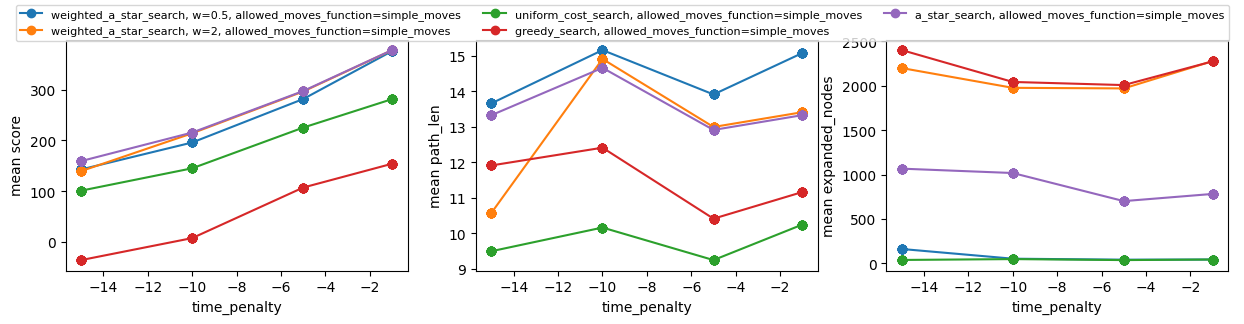

In [4]:
pr.plot_tp_all(plans)

As one can expect, the score increase as the time penalty module decrease.

The A* algorithm gives the maximum score (since it is optimal); also the weighted A* gives good scores, reducing a lot the number of expanded nodes in the parametrization with w = 0.5.

The worst approach both in terms of score and in terms of expanded nodes, is the greedy search algorithm.

In terms of scores, the best achievements are given by the A* and weighted A* algorithms, while the more extreme approaches (uniform cost and greedy) results in lower mean scores.

#### Mean score, path length and number of expanded nodes for the episodes with 5 pieces of gold, varying the grid size:

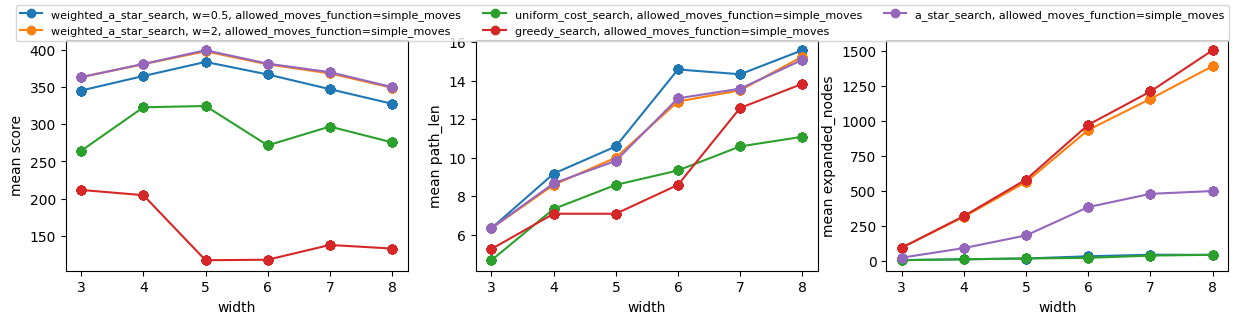

In [5]:
pr.plot_w_all(plans)

As one can expect, increasing the grid size, the number of mean expanded nodes and the mean path length also increase. This is more accentuated in the cases in which the heuristic function has more weight in the search (weighted A* with w = 2 and greedy search).

In terms of score there is no evident increasing or decreasing trend and the differences in the mean values reflect the ones before.

#### A*: Mean score, path length and number of expanded nodes
- for the episodes of grid size $8 \times 8$, varying the time penalty
- for the episodes with 5 pieces of gold, varying the grid size

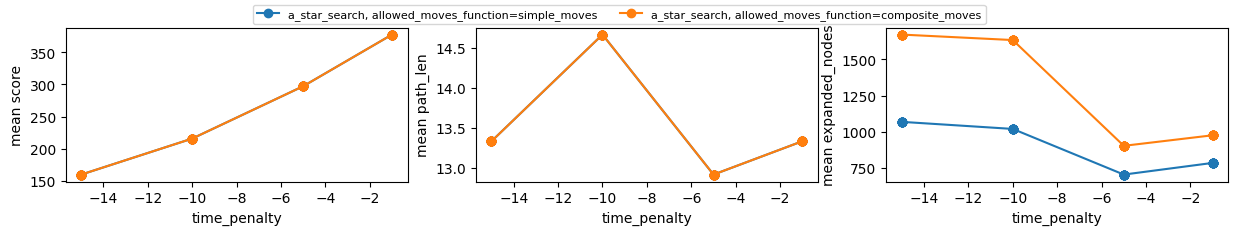

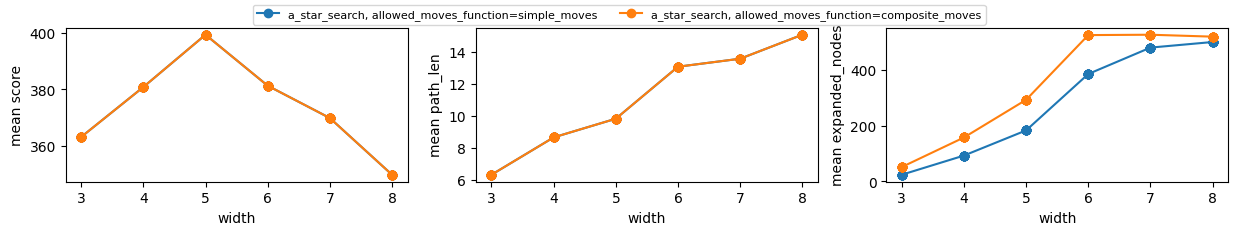

In [3]:
pr.plot_tp_as(plans)
pr.plot_w_as(plans)

There's no difference in score and path length since the A* is optimal both in case of simple and composite moves.

For what concern the number of nodes expanded by the serch, the simple moves approach outperform the simple one.

#### Weighted A*: Mean score, path length and number of expanded nodes
- for the episodes of grid size $8 \times 8$, varying the time penalty
- for the episodes with 5 pieces of gold, varying the grid size

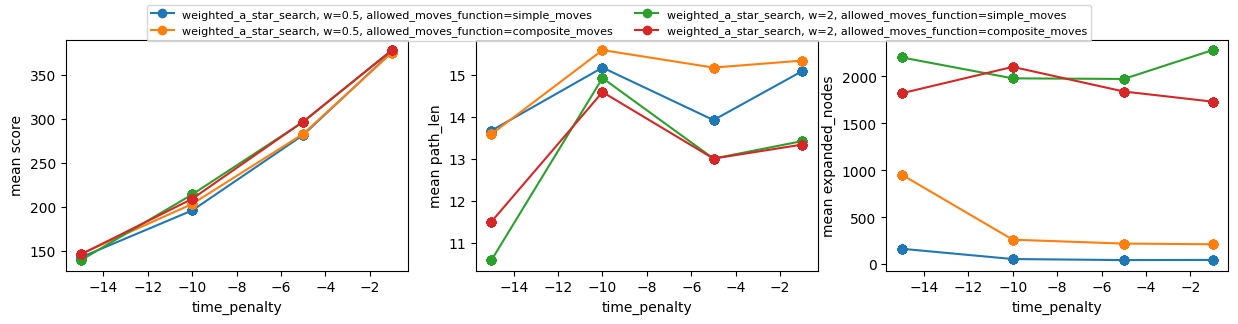

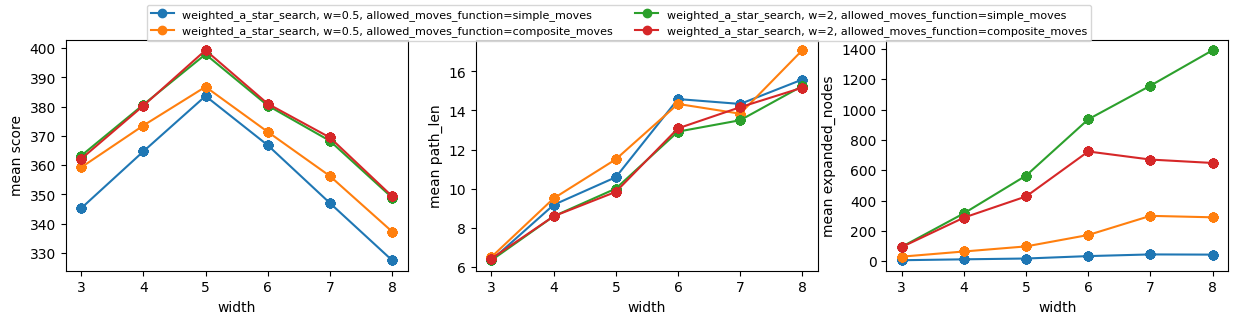

In [5]:
pr.plot_tp_was(plans)
pr.plot_w_was(plans)

We can observe similar performances among the vaious parametrizations in terms of score and path length.

The approaches in which the heuristic has a lower weight (0.5) perform better in terms of expanded nodes.

# Online search

The search algorithms analysed on the non deterministic environment instances are

- `online_greedy_search`:

    - Algorithm which, at each step, selects the action that leads to the maximum valued reachable node.

- `weighted_online_greedy_search`:

    - Instance of `online_greedy_search` in which a weight parameter $w$ can be used to manage the value function (in an analogous way to the case of `weighted_a_star_search`).

- `simulated_annealing`:

    - Implementation of the simulated annealing algorithm.

- `online_random_greedy_search`

    - Algorithm which, at each step, selects the action that leads to the maximum valued reachable node or a random action with a certain probability.

All the listed strategies implement an online search and no memory of the visited states is mantained. This is reasonable, since the environment is non deterministic, i.e. the arrival state resulting from the execution of an action in a starting state cannot be uniquely determined.

The value of a node is computed as the function $v(n') = c_v(n, n') + h_v(n')$, where $c_v$ and $h_v$ are min-max scaled versions of the $h$ and $c$ functions defined for the deterministic scenario.

More formally

$c_v(n, n') = \frac{c(n, n')-min_{m \in \Nu(n)} c(n, m)}{max_{m \in \Nu(n)}c(n,m)-min_{m \in \Nu(n)}c(n,m)}$

$h_v(n) = \frac{h(n)-min_{m \in \Nu(n)} h(m)}{max_{m \in \Nu(n)}h(m)-min_{m \in \Nu(n)}h(m)}$

In the case of `weighted_online_greedy_search` the value of a node is computed as $v(n') = c_v(n, n') + w h_v(n')$, where $w$ is the weight parameter.

## Experiments and results

The details of the experiments can be found in the file `experiment_config.py`, within the dictionary `CONFIG_ONLINE`.

The experiments follow the same approach used for offline planning, except that some leprechauns are now added to the room.

In [ ]:
# Run the episodes
episodes = run_episodes(**CONFIG_ONLINE)

In [2]:
# Load already runned episodes
with open('experiments/episodes.json', 'r') as f:
    episodes = json.load(f)

### Results

#### Mean score, path length and number of expanded nodes for the episodes of grid size $8 \times 8$, varying
- the number of leprechauns
- the time penalty

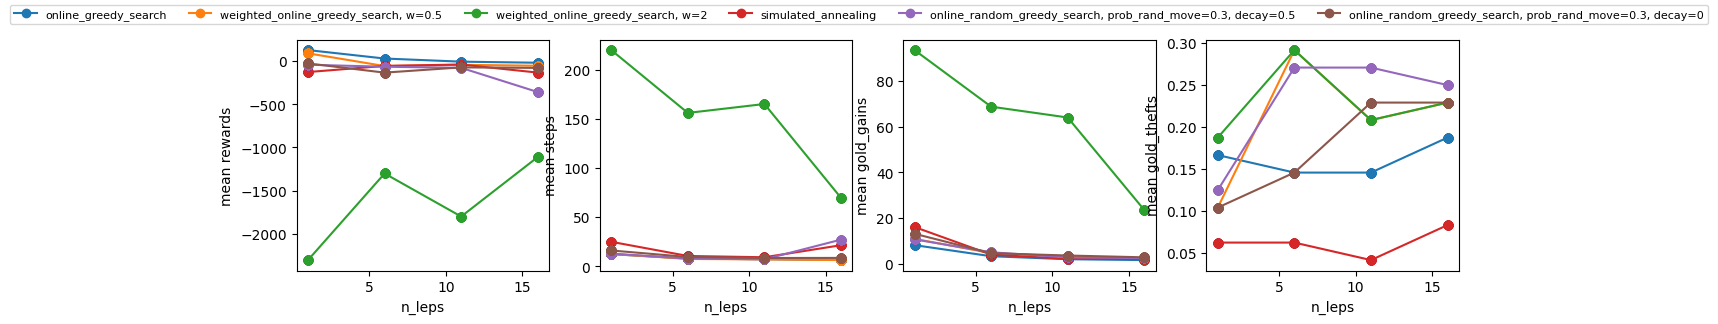

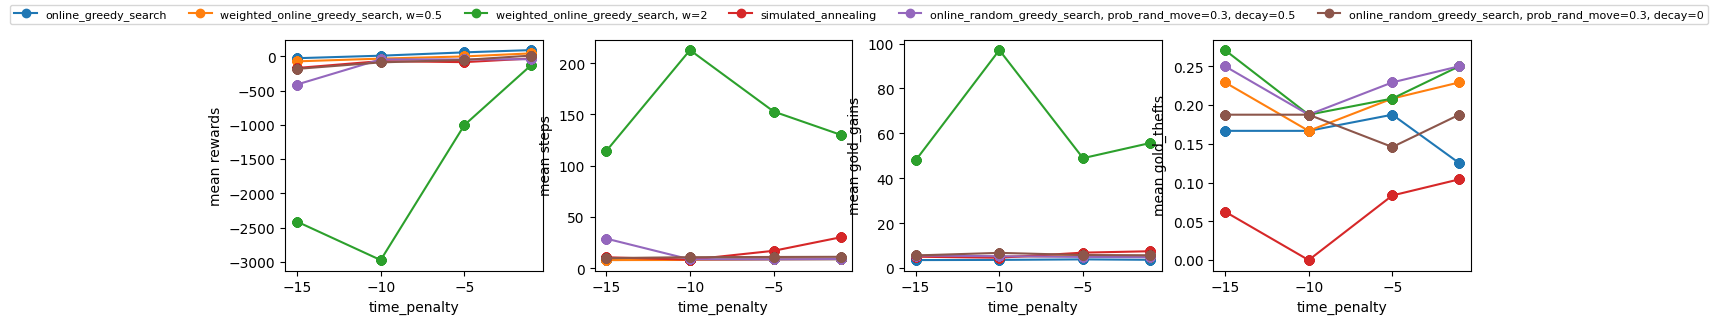

In [3]:
pr.plot_lep_all(episodes)
pr.plot_tp_all2(episodes)

Giving more weight to the 'heuristic' part of the value function (w = 2), the overall performances get drastically worse. This may be due to the degree of nondeterminism of the environment: more the environment is nondeterministic, less effective is to look at the distant future.

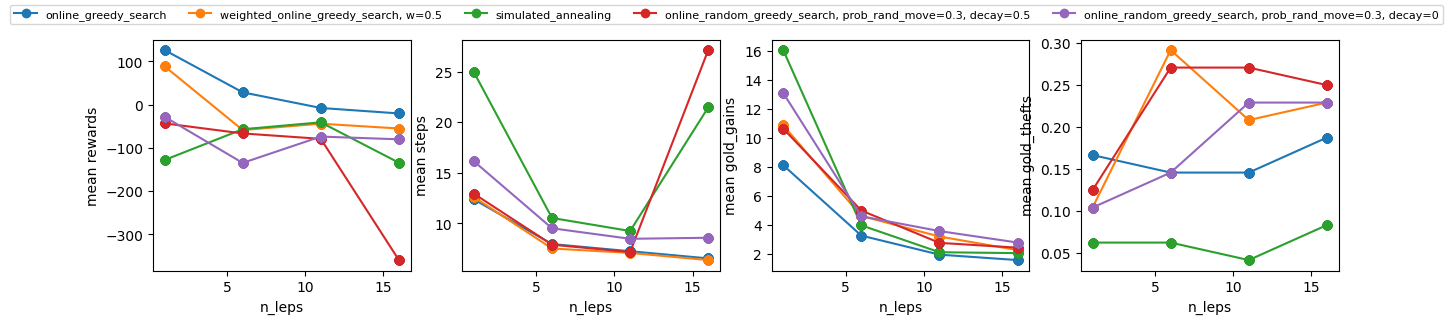

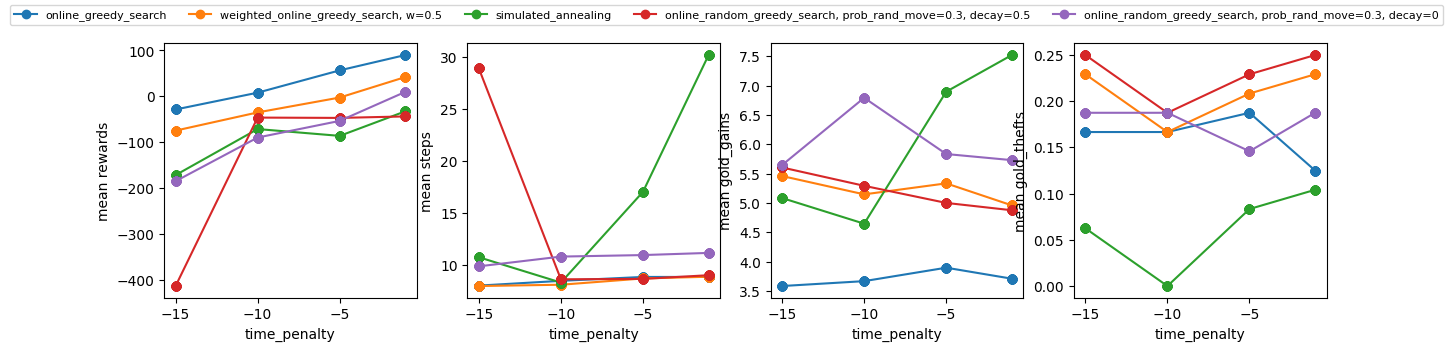

In [4]:
pr.plot_lep_part(episodes)
pr.plot_tp_part(episodes)

The best approach in terms of final score is the online greedy search algorithm; also its weighted variant with w = 0.5 gives good score results: it leads to a higher number of gold gains but also to a higher number of gold thefts.

# Conclusions
Different search algorithms have been tested, adopting different approaches depending on the kind of environment: deterministic or non deterninistic, assuming full observability of the environment state.



The results highlight the influence of the heuristic function, both in terms of performances (score) and in terms of efficiency (number of expanded nodes) of the search algorithms.

Finally, in the deterministic scenarios, a comparison between simple and composite moves strategies has been done.  

# Appendix

## Completeness and optimality of `a_star_search`

Note: In this setting an optimal solution always exists and the search graph is finite, with no positive loops.

In the original classical formulation of the A* algorithm, designed for minimum cost pathfinding, the following conditions are sufficient to guarantee the algorithm's completeness and optimality:
1. The search graph does not present any negative loop.
2. The heuristic function must be admissible, meaning it never overestimates the true cost to reach the goal.

    A stronger condition than admissibility is consistency. An heuristic is consistent (or monotonic) if it guarantees that the estimated cost from any node to the goal is no greater than the cost of reaching a successor plus the estimated cost from the successor to the goal. Consistency implies admissibility and moreover it allows the A* algorithm to do without the expanded node list, keeping completeness and optimality.

These conditions ensure that the A* algorithm will always find the shortest path if one exists and will explore all possible paths if necessary.

First of all let's reformulate the `a_star_search` in terms of an equivalent minimum cost pathfinding algorithm:

At each step the `a_star_search` expand a node according to the following selection criterion

$\arg \max_{n' \in next(n)} g(n') + h(n') = $\
$ = \arg\max_{n' \in next(n)} g(n) + c(n,n') + h(n') = $\
$ = \arg\min_{n' \in next(n)} -g(n) - c(n, n')- h(n') = $\
$ = \arg\min_{n' \in next(n)} \tilde{g}(n) + \tilde{c}(n,n') + \tilde{h}(n') = $\
$ = \arg\min_{n' \in next(n)} \tilde{g}(n') + \tilde{h}(n')$

- $\tilde{g}(n) = - g(n)$,
- $\tilde{c}(n,n') = - c(n,n')$
- $\tilde{h}(n') = - h(n')$

### 1. No negative cycles in the search graph

The search graph of the original formulation does not have any positive loop by construction: once a positive cost edge is percolated, it is no longer percolatable (the node from which the edge emerges is no longer reachable).

In terms of the classical minimum cost pathfinding formulation, no negative cost loop is present in the search graph.

$\square$

### 2. Heuristic consistency: $\tilde{h}(n) \le \tilde{c}(n, n') + \tilde{h}(n')$

$h(n) = \begin{cases} max(\gamma |\Gamma| - \tau f_1(n), \gamma - \tau f_2(n)) \text{ if } p_s \in \Gamma,\\ max(\gamma |\Gamma| - \tau f_1(n), - \tau f_2(n)) \text{ otw} \end{cases},$

$c(n, n') = \begin{cases} -\tau d(p_a, p_a') + \gamma \text{ if } p_a' \in \Gamma,\\ -\tau d(p_a, p_a') \text{ otw} \end{cases}$

We first prove that $h(n) \ge c(n, n') + h(n')$;

then we show that $h(n) \ge c(n, n') + h(n') \implies \tilde{h}(n) \le \tilde{c}(n, n') + \tilde{h}(n')$.

In order to show that $h(n) \ge c(n, n') + h(n')$, we have to distinguish the tree cases:
- **(a)** $\color{red}{h(n) = \gamma|\Gamma| - \tau f_1(n)}:$

    If $c(n,n') = \gamma - \tau d(p_a, p_a')$:

    $h(n')+c(n,n') =$

    - $\color{blue}{\{c(n,n') = \gamma - \tau d(p_a, p_a')\}}$
    
    $= h(n') + \gamma - \tau d(p_a, p_a') \le$
        
    - $\color{blue}{\{h(n') \le -\tau f_2(n') + \gamma |\Gamma'|\}}$

    $\le -\tau f_2(n') + \gamma |\Gamma'| + \gamma -\tau d(p_a, p_a') =$

    - $\color{blue}{\{\gamma |\Gamma'| + \gamma = \gamma |\Gamma|\}}$

    $= -\tau f_2(n') + \gamma |\Gamma| -\tau d(p_a, p_a') =$

    - $\color{blue}{\{f_2(n') = f_1(n)-d(p_a, p_a')\}}$

    $= -\tau (f_1(n)-d(p_a, p_a')) + \gamma |\Gamma| -\tau d(p_a, p_a') =$

    $= -\tau f_1(n)+ \tau d(p_a, p_a') + \gamma |\Gamma| -\tau d(p_a, p_a') =$

    $= -\tau f_1(n) + \gamma |\Gamma| =$
    
    $= h(n)$

    If $c(n,n') = - \tau d(p_a, p_a')$:

    $h(n')+c(n,n') = $

    - $\color{blue}{\{c(n,n') = - \tau d(p_a, p_a')\}}$

    $= h(n') - \tau d(p_a, p_a') \le$
        
    - $\color{blue}{\{h(n') \le -\tau f_2(n') + \gamma |\Gamma'|\}}$

    $\le -\tau f_2(n') + \gamma |\Gamma'|  -\tau d(p_a, p_a') =$

    - $\color{blue}{\{\gamma |\Gamma'| = \gamma |\Gamma|\}}$

    $= -\tau f_2(n') + \gamma |\Gamma| -\tau d(p_a, p_a') =$

    - $\color{blue}{\{f_2(n') = f_1(n)-d(p_a, p_a')\}}$

    $= -\tau (f_1(n)-d(p_a, p_a')) + \gamma |\Gamma| -\tau d(p_a, p_a') =$

    $= -\tau f_1(n)+ \tau d(p_a, p_a') + \gamma |\Gamma| -\tau d(p_a, p_a') =$

    $= -\tau f_1(n) + \gamma |\Gamma| =$
    
    $= h(n)$
    
    So $h(n')+c(n,n') \le h(n)$.

- **(b)** $\color{red}{h(n) = -\tau f_2(n):}$

    $h(n) = -\tau f_2(n)$ means that

    - $\color{blue}{[b1]}$ $-\tau f_2(n) \ge \gamma |\Gamma| -\tau f_1(n)$ 

    - $\color{blue}{[b2]}$ $p_a'$ is on the maximum score path from $p_a$ and $p_s$, so $f_1(n) = d(p_a, p_a') - \tau f_2(n')$ 

    - $\color{blue}{[b3]}$ $c(n, n') = - \tau d(p_a, p_a')$, i.e. there's no gold in $p_a'$, otherwise we are in case **(a)** 

    - $\color{blue}{[b4]}$ $h(n') = -\tau f_2(n')$ 

    $h(n) = -\tau f_2(n) \ge^{\color{blue}{[b1]}} -\tau f_1(n) =^{\color{blue}{[b2]}} -\tau f_2(n') - \tau d(p_a, p_a') =^{\color{blue}{[b3], [b4]}} h(n') + c(n, n')$

    So $h(n) \ge h(n')+c(n,n')$

- **(c)** $\color{red}{h(n) = \gamma -\tau f_2(n):}$

    The fact $h(n) \ge h(n')+c(n,n')$ is a direct condequence of **(b)**.

Now we show that $h(n) \ge h(n')+c(n,n') \implies \tilde{h}(n) \le \tilde{h}(n')+\tilde{c}(n,n')$:

Recall that
- $\tilde{g}(n) = - g(n)$,
- $\tilde{c}(n,n') = - c(n,n')$,
- $\tilde{h}(n) = - h(n)$.

Then

$h(n) \ge h(n')+c(n,n') \implies -h(n) \le -h(n')-c(n,n') \implies \tilde{h}(n) \le \tilde{h}(n')+\tilde{c}(n,n')$.

$\square$

#### Heuristic admissibility

Consistency implies admissibility, i.e.

$\tilde{h}(n) \le \tilde{h}(n')+\tilde{c}(n,n') \implies \tilde{h}(n) \le \tilde{h}^*(n)$,

where $\tilde{h}^*(n_K) = \sum_{i=2}^K \tilde{c}(n_{i-1}, n_i) = - \sum_{i=2}^K \tilde{c}(n_{i-1}, n_i) = -h^*(n_K)$,

($n_1, ..., n_K$ optimal path)

## Conclusion

`a_star_search` is optimal and complete.

## Analysis of completeness and optimality of `weighted_a_star_search`

Weighting the heuristic function, the heuristic admissibility is no longer guaranteed.

Let
- $h^*(n_K) = \sum_{i=2}^K c(n_{i-1}, c_i)$,

- $c(n, n') = \begin{cases} -\tau d(p_a, p_a') + \gamma \text{ if } p_a' \in \Gamma,\\ -\tau d(p_a, p_a') \text{ otw} \end{cases}$

- $h(n) = \begin{cases} max(\gamma |\Gamma| - \tau f_1(n), \gamma - \tau f_2(n)) \text{ if } p_s \in \Gamma,\\ max(\gamma |\Gamma| - \tau f_1(n), - \tau f_2(n)) \text{ otw} \end{cases}$.

We've seen that $\forall n, h(n) \ge h^*(n)$.

In order to analyze when $w h(n) \ge h^*(n)$, we distinguish three cases:

- $h^*(n) \gt 0$:

    - $h(n) \ge h^*(n) \gt 0$, i.e. $h(n) \gt 0$

    - then

        - $w h(n) \ge h^*(n) \iff w \ge \frac{h^*(n)}{h(n)}$,

        - $\frac{h^*(n)}{h(n)} \in (0, 1]$

- $h^*(n) \lt 0$:

    - if $h(n) \gt 0$, then

        - $w h(n) \ge h^*(n) \iff w \ge \frac{h^*(n)}{h(n)}$,
        
        - $\frac{h^*(n)}{h(n)} \in [-1, 0)$

    - if $h(n) \lt 0$, then
        
        - $w h(n) \ge h^*(n) \iff w \le \frac{h^*(n)}{h(n)}$,

        - $\frac{h^*(n)}{h(n)} \in (0, 1]$
    
    - so $w h(n) \ge h^*(n) \iff |w| \le \frac{h^*(n)}{h(n)}$

- $h^*(n) = 0$:

    - $w h(n) \ge h^*(n) \iff w h(n) \ge 0$

## Additional results

#### Uniform cost search: Mean score, path length and number of expanded nodes
- for the episodes of grid size $8 \times 8$, varying the time penalty
- for the episodes with 5 pieces of gold, varying the grid size

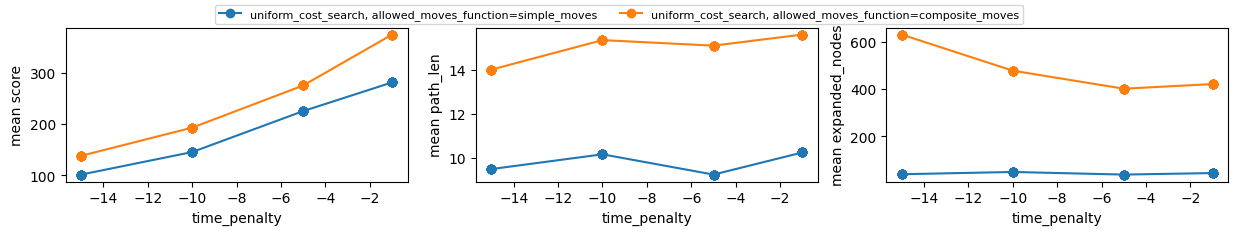

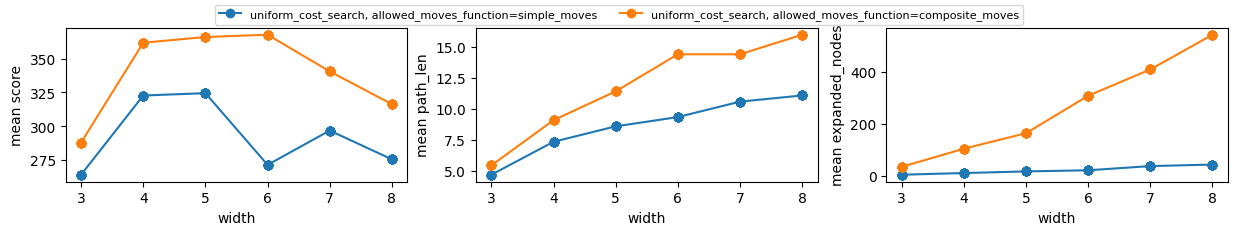

In [6]:
pr.plot_tp_uc(plans)
pr.plot_w_uc(plans)

In terms of score the uniform cost search algorithm performs better in the composite moves scenario, while for what concern the number of expanded nodes, the simple moves approach is more efficient.

#### Greedy search: Mean score, path length and number of expanded nodes
- for the episodes of grid size $8 \times 8$, varying the time penalty
- for the episodes with 5 pieces of gold, varying the grid size

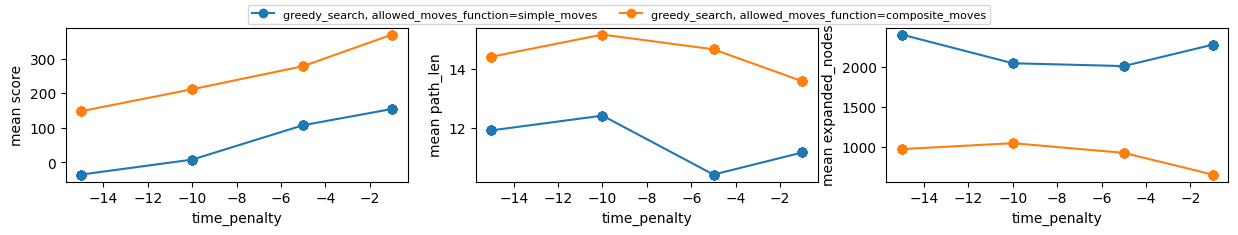

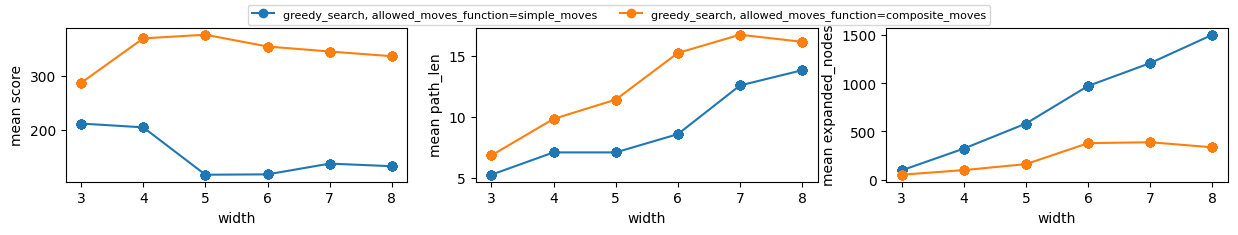

In [7]:
pr.plot_tp_g(plans)
pr.plot_w_g(plans)

In terms of score, as for the uniform cost, the greedy search algorithm performs better in the composite moves scenario, while for what concern the number of expanded nodes, the simple moves approach is more efficient.

## Implementation details

`gold_room_env.py`

- Implementation of the environment class.

`planning.py`

- Implementation of search algorithms used in the deterministic environment instances.

- Note: All the presented planning algorithms are implemented as a particular application of `a_star_search`

`online_search.py`

- Implementation of search algorithms used in the nondeterministic environment instances.

- Note: All the presented online search algorithms are implemented as a particular application of `online_search_f`

`utils.py`

- Functions used by the search algorithms, to run episodes, and to make plots.

`plot_results.py`

- Functions used to plot results

`experiment_config.py`

- Dictionaries that represent the different experimental configurations on which the episodes are runned.

## Examples

### Planning

In [16]:
WIDTH = 8
HEIGHT = 8
N_GOLDS = 4
N_LEPS = 0
GOLD_SCORE = 10
STAIR_SCORE = 0
TIME_PENALTY = -1
MAX_STEPS = 100
WEIGHT = 0.9

w_a_star_search = lambda env, allowed_moves_function: weighted_a_star_search(
    env=env,
    allowed_moves_function= allowed_moves_function,
    w=WEIGHT
)

SEARCH_ALGORITHMS = [a_star_search,a_star_search, w_a_star_search, uniform_cost_search, greedy_search]
ALG_NAMES = ['A*', 'Weighted A*', 'Uniform Cost', 'Greedy']
ALLOWED_MOVES_FUNCTIONS = [ALLOWED_SIMPLE_MOVES, ALLOWED_COMPOSITE_MOVES]
MOVE_NAMES = ['simple moves', 'composite moves']

env = gym.make(
    'MiniHack-MyTask-Custom-v0',
    width=WIDTH,
    height=HEIGHT,
    n_leps=N_LEPS,
    n_golds=N_GOLDS,
    max_episode_steps=MAX_STEPS,
    gold_score=GOLD_SCORE,
    stair_score=STAIR_SCORE,
    time_penalty=TIME_PENALTY
    )

print(f'Starting position: {env.agent_coord}, Stair position: {env.stair_coord}')
print(f'Gold positions: {env.gold_coords}\n')

planning_stats = {}

for search_algorithm, alg_name in zip(SEARCH_ALGORITHMS, ALG_NAMES):
    temp = {}
    for moves_function, moves_name in zip(ALLOWED_MOVES_FUNCTIONS, MOVE_NAMES):
        plan, n_expanded = search_algorithm(env=env, allowed_moves_function=moves_function)
        temp[moves_name] = {
            'algorithm': search_algorithm,
            'moves': moves_name,
            'plan': plan,
            'n_expanded': n_expanded
        }
        print(f'Algorithm: {alg_name} ({moves_name})\nExpanded nodes: {n_expanded}')
        plan.show(env=env)
        print('\n')
    planning_stats[alg_name] = temp

Starting position: (7, 1), Stair position: (3, 1)
Gold positions: [(4, 2), (7, 4), (2, 0), (7, 7)]

Algorithm: A* (simple moves)
Expanded nodes: 354
Path: [(7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (6, 6), (5, 5), (5, 4), (5, 3), (4, 2), (3, 2), (2, 1), (2, 0), (3, 1)]
Actions: ['N', 'N', 'N', 'N', 'N', 'N', 'SW', 'SW', 'S', 'S', 'SW', 'W', 'SW', 'S', 'NE']
Total score: 22.929


Algorithm: A* (composite moves)
Expanded nodes: 213
Path: [(7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (6, 6), (5, 5), (5, 4), (5, 3), (4, 2), (3, 2), (2, 1), (2, 0), (3, 1)]
Actions: ['N', 'N', 'N', 'N', 'N', 'N', 'SW', 'SW', 'S', 'S', 'SW', 'W', 'SW', 'S', 'NE']
Total score: 22.929


Algorithm: Weighted A* (simple moves)
Expanded nodes: 354
Path: [(7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (6, 6), (5, 5), (5, 4), (5, 3), (4, 2), (3, 2), (2, 1), (2, 0), (3, 1)]
Actions: ['N', 'N', 'N', 'N', 'N', 'N', 'SW', 'SW', 'S', 'S', 'SW', 'W', 'SW', 'S', 'NE']
Total score: 22.929




### Applying plans

In [17]:
application_results = {}

for algorithm in ALG_NAMES:
    temp = {}
    for moves in MOVE_NAMES:
        env.myreset()
        states, rewards, done = apply(env, planning_stats[algorithm][moves]['plan'])
        temp[moves] = {
            'states': states,
            'rewards': rewards,
            'done': done
        }
        rws_round = []
        for r in rewards:
            rws_round.append(round(r, 3))
        sum_rws = sum(rewards)
        sum_rws_round = round(sum_rws, 3)
        print(f'{algorithm} ({moves})\nRewards: {rws_round}, sum: {sum_rws_round}\n')
    application_results[algorithm] = temp

A* (simple moves)
Rewards: [0, -1.0, -1.0, 9.0, -1.0, -1.0, 9.0, -1.414, -1.414, -1.0, -1.0, 8.586, -1.0, -1.414, 9.0, -1.414], sum: 22.929

A* (composite moves)
Rewards: [0, -1.0, -1.0, 9.0, -1.0, -1.0, 9.0, -1.414, -1.414, -1.0, -1.0, 8.586, -1.0, -1.414, 9.0, -1.414], sum: 22.929

Weighted A* (simple moves)
Rewards: [0, -1.0, -1.0, 9.0, -1.0, -1.0, 9.0, -1.414, -1.414, -1.0, -1.0, 8.586, -1.0, -1.414, 9.0, -1.414], sum: 22.929

Weighted A* (composite moves)
Rewards: [0, -1.0, -1.0, 9.0, -1.0, -1.0, 9.0, -1.414, -1.414, -1.0, -1.0, 8.586, -1.0, -1.414, 9.0, -1.414], sum: 22.929

Uniform Cost (simple moves)
Rewards: [0, -1.0, -1.0, 9.0, -1.0, -1.0, 9.0, -1.414, -1.0, -1.414, -1.0, 8.586, -1.0, -1.414, 9.0, -1.414], sum: 22.929

Uniform Cost (composite moves)
Rewards: [0, -1.0, -1.0, 9.0, -1.0, -1.0, 9.0, -1.414, -1.0, -1.414, -1.0, 8.586, -1.0, -1.414, 9.0, -1.414], sum: 22.929

Greedy (simple moves)
Rewards: [0, -1.0, -1.0, 9.0, -1.0, -1.0, 9.0, -1.0, -1.0, -1.414, -1.414, 8.586, -1.

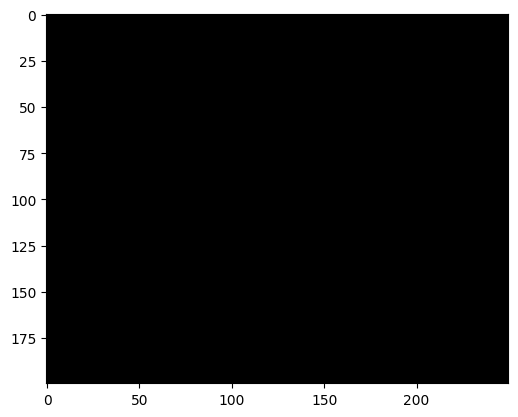

In [18]:
show_episode(application_results['A*']['simple moves']['states'], clear_output=True)

### Online search

In [14]:
WIDTH = 8
HEIGHT = 8
N_GOLDS = 8
N_LEPS = 5
GOLD_SCORE = 100
STAIR_SCORE = 0
TIME_PENALTY = -1
MAX_STEPS = 100
WEIGHT = 2

w_online_greedy_search = lambda env, max_steps: weighted_online_greedy_search(
    env=env,
    max_steps=max_steps,
    w=WEIGHT
)

SEARCH_ALGORITHMS = [online_greedy_search, w_online_greedy_search, online_random_greedy_search, simulated_annealing]
ALG_NAMES = ['online_greedy_search', 'w_online_greedy_search', 'online_random_greedy_search', 'simulated_annealing']

env = gym.make(
    'MiniHack-MyTask-Custom-v0',
    width=WIDTH,
    height=HEIGHT,
    n_leps=N_LEPS,
    n_golds=N_GOLDS,
    max_episode_steps=MAX_STEPS,
    gold_score=GOLD_SCORE,
    stair_score=STAIR_SCORE,
    time_penalty=TIME_PENALTY
    )

print(f'Starting position: {env.agent_coord}, Stair position: {env.stair_coord}')
print(f'Gold positions: {env.gold_coords}\n')

application_results = {}

for search_algorithm, alg_name in zip(SEARCH_ALGORITHMS, ALG_NAMES):
    env.myreset()
    states, rewards, done, iters, steps = search_algorithm(env=env, max_steps=MAX_STEPS)
    temp = {
            'states': states,
            'rewards': rewards,
            'done': done,
            'iters': iters,
            'steps': steps
        }
    rws_round = [round(r, 3) for r in rewards]
    sum_rws_round = round(sum(rewards), 3)
    print(f'{alg_name}\nRewards: {rws_round}, sum: {sum_rws_round}\n')
    application_results[alg_name] = temp

Starting position: (6, 2), Stair position: (0, 4)
Gold positions: [(7, 3), (6, 4), (2, 6), (4, 3), (1, 3), (0, 2), (7, 0), (1, 5)]

online_greedy_search
Rewards: [0.0, 98.586, -101.414, -1.0, 98.586, -1.414, -1.0, -1.0, -1.0], sum: 90.343

w_online_greedy_search
Rewards: [0.0, 98.586, -201.414, -1.0, 98.586, -1.414, -1.0, -1.0, -1.0], sum: -9.657

online_random_greedy_search
Rewards: [0.0, 98.586, -201.414, -1.0, -1.0, 99.0, -1.414, -1.414, -1.0, -101.414, -1.414, -1.414, -1.0, -1.414, -1.414, -1.0, -1.0, -1.0, -1.0, -1.0, -1.414], sum: -124.142

simulated_annealing
Rewards: [0.0, -1.0, -1.414, -1.0, -1.0], sum: -4.414



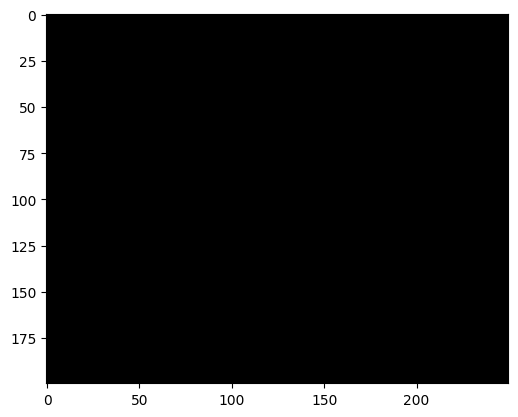

In [15]:
show_episode(application_results['online_greedy_search']['states'], clear_output=True)

## Contributions

- *Claudia Gentili*: Focused the development and implementation of search algorithms, proving the admissibility and consistency of the heuristic, and formally defining the environment states, cost, and heuristic functions used.

- *Federico Cioni*: Developed the interface and interaction mechanisms with the environment using the Minihack library and Gym, ensuring seamless integration and effective communication between the algorithms and the simulation environment.

- *Giovanni Guerrazzi*: Responsible for overseeing and executing the simulations, recording data, analyzing results, and creating insightful visual representations with plots.